#Lab 7: Heart Attack

In [1]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer, make_column_selector
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import  r2_score, classification_report, roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel


In [2]:
ha = pd.read_csv("https://www.dropbox.com/s/aohbr6yb9ifmc8w/heart_attack.csv?dl=1")

In [3]:
good_cols = ha.isna().sum() < 100
ha = ha.loc[:,good_cols]

# Drop other NAs
ha = ha.dropna()

##Part One: Fitting Models
This section asks you to create a final best model for each of the model types studied this week. For each, you should:

Find the best model based on ROC AUC for predicting the target variable.

Report the (cross-validated!) ROC AUC metric.

Fit the final model.

Output a confusion matrix; that is, the counts of how many observations fell into each predicted class for each true class.

(Where applicable) Interpret the coefficients and/or estimates produced by the model fit.

You should certainly try multiple model pipelines to find the best model. You do not need to include the output for every attempted model, but you should describe all of the models explored. You should include any hyperparameter tuning steps in your writeup as well.

In [4]:
X = ha.drop(["output"], axis = 1)
y = ha["output"]

ct = ColumnTransformer(
  [
    ("dummify",
    OneHotEncoder(sparse_output = False, handle_unknown='ignore'),
    make_column_selector(dtype_include=object)),
    ("standardize",
    StandardScaler(),
    make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
)

###Q1: KNN

In [16]:
knn_pipeline = Pipeline([
    ("preprocessing", ct),
    ("knn", KNeighborsClassifier())
])

# Define the hyperparameter grid
nn = {'knn__n_neighbors': range(1, 30)}
#had to use 30 since thats the number of samples in the second part

# Perform grid search
knngrid = GridSearchCV(knn_pipeline, nn, cv=5, scoring='roc_auc')  # Ensure scoring is valid for classification
knngrid.fit(X, y)  # X and y should correspond to your dataset (classification)

# Get the best number of neighbors
bestknn = knngrid.best_params_['knn__n_neighbors']

# Create a final pipeline with the best parameters
knn_final_pipeline = Pipeline([
    ("preprocessing", ct),
    ("knn", KNeighborsClassifier(n_neighbors=bestknn))
])
knnfitt=knn_final_pipeline.fit(X, y)

#results
print("Best Knn:", knngrid.best_params_)
print("Best cross validated ROC AUC:", knngrid.best_score_)

#classifier
y_predknn = knn_final_pipeline.predict(X)
print("Confusion Matrix:")
print(confusion_matrix(y, y_predknn))

Best Knn: {'knn__n_neighbors': 17}
Best cross validated ROC AUC: 0.8408498673740052
Confusion Matrix:
[[ 90  37]
 [ 21 125]]


###Q2: Logistic Regression

In [7]:
logreg_pipeline = Pipeline([
    ("preprocessing", ct),
    ("logreg", LogisticRegression(max_iter=1000))  # Logistic Regression with increased iterations for convergence
])
# Define the hyperparameter grid
logreg_params = {
    'logreg__C': [0.01, 0.1, 1, 10, 100]
}

# Perform grid search
loggrid = GridSearchCV(logreg_pipeline, logreg_params, cv=5, scoring='roc_auc')
loggrid.fit(X, y)

# Get the best hyperparameters
best_logreg_params = loggrid.best_params_['logreg__C']

# Create a final pipeline with the best parameters
logreg_final_pipeline = Pipeline([
    ("preprocessing", ct),
    ("logreg", LogisticRegression(
        C=best_logreg_params,
        max_iter=1000
    ))
])
logregfit=logreg_final_pipeline.fit(X, y)

#results
print("Best Logistic Regression Parameters:")
print("C:", best_logreg_params)
print("Best cross validated ROC AUC:", loggrid.best_score_)

#classifier
y_predlogreg = logreg_final_pipeline.predict(X)
print("Confusion Matrix:")
print(confusion_matrix(y, y_predlogreg))

Best Logistic Regression Parameters:
C: 0.01
Best cross validated ROC AUC: 0.8546433244916003
Confusion Matrix:
[[ 88  39]
 [ 19 127]]


###Q3: Decision Tree

In [12]:
dt_pipeline = Pipeline([
    ("preprocessing", ct),
    ("decision_tree", DecisionTreeClassifier())
])

# Hyperparameter grid for 'min_impurity_decrease'
dtt = {'decision_tree__min_impurity_decrease': [0.0, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}

# Perform grid search
dec_grid = GridSearchCV(dt_pipeline, dtt, cv=5, scoring='roc_auc')
dec_grid.fit(X, y)

# Get the best hyperparameters
best_impurity_decrease = dec_grid.best_params_['decision_tree__min_impurity_decrease']

# Create a final pipeline using the best 'min_impurity_decrease'
dt_final_pipeline = Pipeline([
    ("preprocessing", ct),
    ("decision_tree", DecisionTreeClassifier(min_impurity_decrease=best_impurity_decrease))
])

# Fit the final model
dtfitted = dt_final_pipeline.fit(X, y)

# Results
print("Best Decision Tree Parameters:")
print("Min Impurity Decrease:", best_impurity_decrease)
print("Best cross-validated ROC AUC:", dec_grid.best_score_)

# Classifier evaluation
y_preddt = dt_final_pipeline.predict(X)
print("Confusion Matrix:")
print(confusion_matrix(y, y_preddt))

Best Decision Tree Parameters:
Min Impurity Decrease: 0.01
Best cross-validated ROC AUC: 0.7673043324491601
Confusion Matrix:
[[ 92  35]
 [ 14 132]]


###Q4: Interpretation
Which predictors were most important to predicting heart attack risk?

In [15]:

#coefficients for logisitc regression
coeflr = logreg_final_pipeline.named_steps["logreg"].coef_[0]  # Extract coefficients
featrelr = pd.DataFrame({"feature": X.columns, "coefficient": coeflr})  # Create DataFrame
featrelr = featrelr.sort_values(by="coefficient", key=abs, ascending=False)  # Sort by absolute coefficient values
print(featrelr)

   feature  coefficient
2       cp     0.302322
6  thalach     0.280505
1      sex    -0.252337
0      age    -0.136729
3   trtbps    -0.097634
5  restecg     0.086628
4     chol    -0.054690


The three most important predictor varaibles for heart disease is CP, Thalach, and Sex. I looked at the logistic regression coefficents because it was the model with the highest ROC AUC.

###Q5: ROC Curve
Plot the ROC Curve for your three models above.

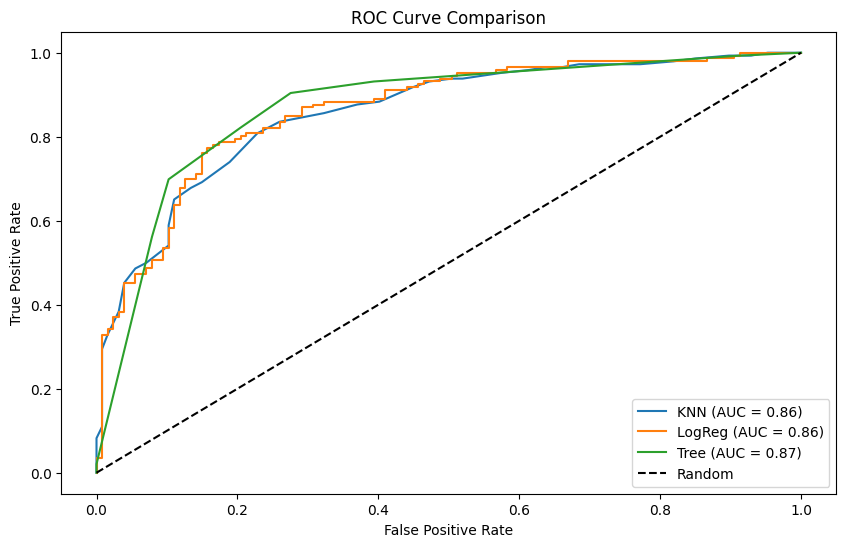

In [13]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
for model, label in zip([knngrid, loggrid, dec_grid], ["KNN", "LogReg", "Tree"]):
    y_score = model.predict_proba(ha.drop("output", axis=1))[:, 1]
    fpr, tpr, _ = roc_curve(ha["output"], y_score)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{label} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], "k--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()

##Part Two: Metrics
Consider the following metrics:

True Positive Rate or Recall or Sensitivity = Of the observations that are truly Class A, how many were predicted to be Class A?

Precision or Positive Predictive Value = Of all the observations classified as Class A, how many of them were truly from Class A?

True Negative Rate or Specificity or Negative Predictive Value = Of all the observations classified as NOT Class A, how many were truly NOT Class A?

Compute each of these metrics (cross-validated) for your three models (KNN, Logistic Regression, and Decision Tree) in Part One.

In [14]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, recall_score, precision_score, make_scorer
import numpy as np
#chat helped me write this function
# Initialize a dictionary to store metrics
metrics = {}

# Helper function to compute True Negative Rate (Specificity)
def specificity_score(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    TN = cm[0, 0]
    FP = cm[0, 1]
    return TN / (TN + FP)

# Compute metrics for each model
for model_name, pipeline in [
    ("Logistic Regression", logreg_final_pipeline),
    ("KNN", knn_final_pipeline),
    ("Decision Tree", dt_final_pipeline)
]:
    # Get cross-validated predictions
    y_pred_cv = cross_val_predict(pipeline, X, y, cv=5)

    # Confusion matrix
    cm = confusion_matrix(y, y_pred_cv)
    TN, FP, FN, TP = cm.ravel()

    # Calculate metrics
    tpr = recall_score(y, y_pred_cv)  # True Positive Rate (Sensitivity/Recall)
    precision = precision_score(y, y_pred_cv)  # Precision (Positive Predictive Value)
    specificity = specificity_score(y, y_pred_cv)  # True Negative Rate (Specificity)

    # Store metrics
    metrics[model_name] = {
        "True Positive Rate (Recall)": tpr,
        "Precision": precision,
        "True Negative Rate (Specificity)": specificity
    }

# Display the results
for model, scores in metrics.items():
    print(f"\n{model}:")
    for metric, value in scores.items():
        print(f"{metric}: {value:.4f}")


Logistic Regression:
True Positive Rate (Recall): 0.8699
Precision: 0.7427
True Negative Rate (Specificity): 0.6535

KNN:
True Positive Rate (Recall): 0.8219
Precision: 0.7692
True Negative Rate (Specificity): 0.7165

Decision Tree:
True Positive Rate (Recall): 0.7534
Precision: 0.7857
True Negative Rate (Specificity): 0.7638


##Part Three: Discussion
Suppose you have been hired by a hospital to create classification models for heart attack risk.

The following questions give a possible scenario for why the hospital is interested in these models. For each one, discuss:

Which metric(s) you would use for model selection and why.

Which of your final models (Part One Q1-3) you would recommend to the hospital, and why.

What score you should expect for your chosen metric(s) using your chosen model to predict future observations.

###Q1
The hospital faces severe lawsuits if they deem a patient to be low risk, and that patient later experiences a heart attack.

The hospital wants to prevent classifing someone as not in risk of a heart disease. They want to prevent false negatives. They want to do this in order to prevent possibly being sued by people that were falsley give an all clear sign than had an actual heart problem. This way they can prevent possibly being sued by people. In order to do this they want to insure a high recall. So for this I would recommend using the logisitic regression model because it has the highest recall rate. So it's the most effect at identifying true positives. The exepect score would be .8699.

###Q2
The hospital is overfull, and wants to only use bed space for patients most in need of monitoring due to heart attack risk.

The hosiptal wants to prevent giving out beds to people who don't need beds. So they would try to reduce the amount of false positives to make sure they only allocate beds to the people who actually need it. So they would focus on precision. For precision I would recommend using the decsicion tree model because it has the highest precision rate making it the best at accuratly identifing true positives. The expected score would be .7857.

###Q3
The hospital is studying root causes of heart attacks, and would like to understand which biological measures are associated with heart attack risk.

In this case the hospital wants to understand the relationships behind the models in identifiying the key varaibles that are related to heart attacks. So it would be more effective if the hospital looks at the key variables in the models instead. Speciicaaly the logistic regression model or the decision tree model. This is because the logistic regression fit the model the best so looking at the coeficents of the model would show which variables are the most important. And for the decision tree by looking at where the model branches you see what the most important factors are.

###Q4
The hospital is training a new batch of doctors, and they would like to compare the diagnoses of these doctors to the predictions given by the algorithm to measure the ability of new doctors to diagnose patients.

The hospital wants to evaluate the difference between predictions made by the mdoel with what the doctors diagnosis someone with. They goal is for the model to match what the doctors diagnosis is. This way the accuracy of both the model and the doctors would be correct. So to compare this the hospital should focus on accuracy. THis way they can see exactly how many time the model differs from the doctors. I would reccomend the KNN as the model of choice because it has a balance of recall at .82, with precision at .76 and specificity at .71. So for knn you can assume an accuracy score of .77.

##Part Four: Validation
Before sharing the dataset with you, I set aside a random 10% of the observations to serve as a final validation set.

ha_validation = pd.read_csv("https://www.dropbox.com/s/jkwqdiyx6o6oad0/heart_attack_validation.csv?dl=1")
Use each of your final models in Part One Q1-3, predict the target variable in the validation dataset.

For each, output a confusion matrix, and report the ROC AUC, the precision, and the recall.

Compare these values to the cross-validated estimates you reported in Part One and Part Two. Did our measure of model success turn out to be approximately correct for the validation data?

In [17]:
ha_validation = pd.read_csv("https://www.dropbox.com/s/jkwqdiyx6o6oad0/heart_attack_validation.csv?dl=1")
good_cols = ha_validation.isna().sum() < 100
ha_validation = ha_validation.loc[:,good_cols]
\ha_validation = ha_validation.dropna()

X2= ha_validation.drop(["output"], axis = 1)
y2= ha_validation["output"]

#knn
knnfitt=knn_final_pipeline.fit(X2, y2)

#results
print("Best Knn:", knngrid.best_params_)
print("Best cross validated ROC AUC:", knngrid.best_score_)

#classifier
y2_predknn = knn_final_pipeline.predict(X2)
print("Confusion Matrix Knn:")
print(confusion_matrix(y2, y2_predknn))

#Logistic regression
logregfit=logreg_final_pipeline.fit(X2, y2)

#results
print("Best Logistic Regression Parameters:")
print("C:", best_logreg_params)
print("Best cross validated ROC AUC:", loggrid.best_score_)

#classifier
y2_predlogreg = logreg_final_pipeline.predict(X2)
print("Confusion Matrix log:")
print(confusion_matrix(y2, y2_predlogreg))

#decision tree
dtfitted=dt_final_pipeline.fit(X2, y2)

#results
print("Best Decision Tree Parameters:")
print("Max Depth:", best_depth)
print("Best cross validated ROC AUC:", dec_grid.best_score_)

#classifier
y2_preddt = dt_final_pipeline.predict(X2)
print("Confusion Matrix dt:")
print(confusion_matrix(y2, y2_preddt))

Best Knn: {'knn__n_neighbors': 17}
Best cross validated ROC AUC: 0.8408498673740052
Confusion Matrix Knn:
[[ 1 10]
 [ 0 19]]
Best Logistic Regression Parameters:
C: 0.01
Best cross validated ROC AUC: 0.8546433244916003
Confusion Matrix log:
[[ 0 11]
 [ 0 19]]
Best Decision Tree Parameters:
Max Depth: 0.01
Best cross validated ROC AUC: 0.7673043324491601
Confusion Matrix dt:
[[11  0]
 [ 0 19]]


##Part Five: Cohen’s Kappa
Another common metric used in classification is Cohen’s Kappa.

Use online resources to research this measurement. Calculate it for the models from Part One, Q1-3, and discuss reasons or scenarios that would make us prefer to use this metric as our measure of model success. Do your conclusions from above change if you judge your models using Cohen’s Kappa instead? Does this make sense?

In [17]:
from sklearn.metrics import cohen_kappa_score, confusion_matrix
from sklearn.model_selection import cross_val_predict

# Initialize a dictionary to store metrics
kappa_scores = {}

# Compute Cohen's Kappa for each model
for model_name, pipeline in [
    ("Logistic Regression", logreg_final_pipeline),
    ("KNN", knn_final_pipeline),
    ("Decision Tree", dt_final_pipeline)
]:
    # Get cross-validated predictions
    y_pred_cv = cross_val_predict(pipeline, X, y, cv=5)

    # Calculate Cohen's Kappa
    kappa = cohen_kappa_score(y, y_pred_cv)

    # Store the score
    kappa_scores[model_name] = kappa

# Display the results
for model, kappa in kappa_scores.items():
    print(f"{model} Cohen's Kappa: {kappa:.4f}")


Logistic Regression Cohen's Kappa: 0.5302
KNN Cohen's Kappa: 0.5264
Decision Tree Cohen's Kappa: 0.5095


....